### Notebook that probes that missense mutations in degrons significantly stabilize the proteins using TCGA data.
- Figure 3d all mutations in degrons (CNA<=1)
- Figure 3e, classified by level of confidence (CNA<=1)


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import gridspec
from scipy import stats

### paths

In [2]:
base="../../" 


dataset_rppa_irls = os.path.join(base,"data/rppa_matched_irls.tsv.gz")
path_output_missense_degrons_rppa = os.path.join(base,"data","missense_clean_type_rppa.tsv.gz")
path_output_indels_degrons_rppa = os.path.join(base,"data","indels_clean_type_rppa.tsv.gz")


output_path_plots = os.path.join(base,"plots/Figure3/")

In [3]:
path_output_missense_degrons_rppa

'/workspace/projects/ubiquitins/codereview/degradation/data/missense_clean_type_rppa.tsv.gz'

# Load rppa information from TCGA

In [4]:
df_missense_raw = pd.read_csv(path_output_missense_degrons_rppa,sep="\t",compression="gzip")
df_all_rppa = pd.read_csv(dataset_rppa_irls,sep="\t",compression="gzip")

### Filter both datasets 
- Remove Samples with alteractions upstream E3ligase
- high-level amplifications/deletions
- mutations that disrupt the epitope and desestabilizes the protein
- remove TP53 for the analysis 

In [5]:
# Raw data
df_missense_raw = pd.read_csv(path_output_missense_degrons_rppa,sep="\t",compression="gzip")
df_indels_raw = pd.read_csv(path_output_indels_degrons_rppa,sep="\t",compression="gzip")
phenotypes = ["In_Frame_Altering_Motif","In_Frame_Altering_Flanking_Degron"]
# Prepare the datasets 
# Wild type
df_wt = df_all_rppa[(df_all_rppa["Phenotype"]=="WT")&(df_all_rppa["CNA"]<=0)&(df_all_rppa["CNA"]>=0)&(df_all_rppa["Hugo_Symbol"]!="TP53")&(~df_all_rppa["Altered_E3_Ligases"])]
df_wt["Type"] = "WT"
df_wt["DEGRON"] ="-"
df_wt["Class"] = "NON-DEGRON"
df_wt["Prob_DEGRON"] = 0.0 
df_wt["Annotated"] = "NO" 
# Other alterations
# Missense
df_missense_other = df_missense_raw[(df_missense_raw["Type_Missense"]=="Other_Missense")&(df_missense_raw["CNA"]<=0)&(df_missense_raw["CNA"]>=0)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_other["Type"] = "Other_Alterations"
# Indels
df_indels_other = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"]=="Other_In_Frame")&(df_indels_raw["Phenotype"].str.contains("In_Frame"))&(df_indels_raw["CNA"]<=0)&(df_indels_raw["CNA"]>=0)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_other["Type"] = "Other_Alterations"
# Alterations degron

# missense
df_missense_degron= df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Altering_Motif")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=0)&(df_missense_raw["CNA"]>=0)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_degron["Type"] = "Alteration_Degron"
# indel
df_indels_degron = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].isin(phenotypes))&(df_indels_raw["CNA"]<=0)&(df_indels_raw["CNA"]>=0)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_degron["Type"] = "Alteration_Degron"

# ALterations PTM

df_missense_ptm = df_missense_raw[(df_missense_raw["Type_Missense"]=="Mutation_Flanking_PTM")&(df_missense_raw["Phenotype"]=="Missense_Mutation")&(df_missense_raw["CNA"]<=0)&(df_missense_raw["CNA"]>=0)&(df_missense_raw["Hugo_Symbol"]!="TP53")&(~df_missense_raw["Altered_E3_Ligases"])&(~((df_missense_raw["Disrupt_Epitope"])&(df_missense_raw["Stability_Change"]<0)))]
df_missense_ptm["Type"] = "Alteration_Degron_PTM"
# indel
df_indels_ptm = df_indels_raw[(df_indels_raw["Type_In_Frame_Alteration"].str.contains("In_Frame_Altering_PTM_Flanking"))&(df_indels_raw["CNA"]<=0)&(df_indels_raw["CNA"]>=0)&(df_indels_raw["Hugo_Symbol"]!="TP53")&(~df_indels_raw["Altered_E3_Ligases"])&(~((df_indels_raw["Disrupt_Epitope"])&(df_indels_raw["Stability_Change"]<0)))]
df_indels_ptm["Type"] = "Alteration_Degron_PTM"


columns = ["Type","Stability_Change","Phenotype","Matchable_Sample_ID","Protein","Prob_DEGRON","DEGRON","Class","Annotated","VAF"]


df_total = pd.concat([df_wt[columns],df_missense_other[columns],df_indels_other[columns],df_missense_degron[columns],df_indels_degron[columns],df_missense_ptm[columns],df_indels_ptm[columns]])
df_total.VAF = df_total.VAF.astype(float)


/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/fran/Downloads/yes/envs/regression/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

### Visualize the categories

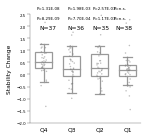

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(2, 2.)
size_strip = 3
p = {"Other_Alterations":"#cc0000","Alteration_Degron":"#d98cb3","WT":"#4682B4","Alteration_Degron_PTM":"#6FBC5F"}
s = ["Alteration_Degron","Alteration_Degron_PTM","Other_Alterations","WT"]
proteins_query = df_total[((df_total["Type"].isin(["Alteration_Degron","Alteration_Degron_PTM"]))&(df_total["Prob_DEGRON"]>0.5))]["Protein"].unique()
data = df_total[(df_total["Type"].isin(["Alteration_Degron","Alteration_Degron_PTM"]))&(df_total["Prob_DEGRON"]>0.5)]
data = data[np.isfinite(data["VAF"])]
d = pd.qcut(data["VAF"].values, 4, labels=["Q1","Q2","Q3","Q4"])
data["Quartile"] = d
sns.boxplot(x="Quartile",y="Stability_Change",data=data,width=0.6,saturation=0.7,order=["Q4","Q3","Q2","Q1"],fliersize=0.,ax=ax, linewidth=1.25,whis=0.9,notch=False,color="white")
g = sns.stripplot(x="Quartile",y="Stability_Change",data=data,order=["Q4","Q3","Q2","Q1"],alpha=0.5,size=1.5,color="grey",jitter=True,dodge=True)


# Numer of mutations motif

N_q4= data[data["Quartile"]=="Q4"].shape[0]
N_q3 = data[data["Quartile"]=="Q3"].shape[0]
N_q2 = data[data["Quartile"]=="Q2"].shape[0]
N_q1 = data[data["Quartile"]=="Q1"].shape[0]

# Write numbers of N

maxv = np.nanmax(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values)+list(list(data[data["Type"]=="Alteration_Degron_PTM"]["Stability_Change"].values)))
minv = np.nanmin(list(data[data["Type"]=="Alteration_Degron"]["Stability_Change"].values)+list(list(data[data["Type"]=="Alteration_Degron_PTM"]["Stability_Change"].values)))

maxv = 1.5
minv = -1.5

ax.text(y=maxv+0.4,x=-0.15,s="N="+str(N_q4),fontsize=6)
ax.text(y=maxv+0.4,x=0.85,s="N="+str(N_q3),fontsize=6)
ax.text(y=maxv+0.4,x=1.75,s="N="+str(N_q2),fontsize=6)
ax.text(y=maxv+0.4,x=2.55,s="N="+str(N_q1),fontsize=6)



# Calculate significance 

# Annotated

pvalue_q4 = stats.mannwhitneyu(data[data["Quartile"]=="Q4"]["Stability_Change"].values,df_total[df_total["Type"]=="Other_Alterations"]["Stability_Change"].values)[1]
pvalue_q3 = stats.mannwhitneyu(data[data["Quartile"]=="Q3"]["Stability_Change"].values,df_total[df_total["Type"]=="Other_Alterations"]["Stability_Change"].values)[1]
pvalue_q2 = stats.mannwhitneyu(data[data["Quartile"]=="Q2"]["Stability_Change"].values,df_total[df_total["Type"]=="Other_Alterations"]["Stability_Change"].values)[1]
pvalue_q1 = stats.mannwhitneyu(data[data["Quartile"]=="Q1"]["Stability_Change"].values,df_total[df_total["Type"]=="Other_Alterations"]["Stability_Change"].values)[1]

pvalue_q4_wt = stats.mannwhitneyu(data[data["Quartile"]=="Q4"]["Stability_Change"].values,df_total[df_total["Type"]=="WT"]["Stability_Change"].values)[1]
pvalue_q3_wt = stats.mannwhitneyu(data[data["Quartile"]=="Q3"]["Stability_Change"].values,df_total[df_total["Type"]=="WT"]["Stability_Change"].values)[1]
pvalue_q2_wt = stats.mannwhitneyu(data[data["Quartile"]=="Q2"]["Stability_Change"].values,df_total[df_total["Type"]=="WT"]["Stability_Change"].values)[1]
pvalue_q1_wt = stats.mannwhitneyu(data[data["Quartile"]=="Q1"]["Stability_Change"].values,df_total[df_total["Type"]=="WT"]["Stability_Change"].values)[1]

# Quartile 4


if pvalue_q4_wt < 0.01:
    ax.text(y=maxv+1.2,x=-0.25,s="P="+str("{0:.2E}".format(pvalue_q4_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=-0.25,s="P=n.s.",fontsize=4)

if pvalue_q4 < 0.01:
    ax.text(y=maxv+0.8,x=-0.25,s="P="+str("{0:.2E}".format(pvalue_q4)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=-0.25,s="P=n.s.",fontsize=4)

# Quartile 3 


if pvalue_q3_wt < 0.01:
    ax.text(y=maxv+1.2,x=0.85,s="P="+str("{0:.2E}".format(pvalue_q3_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=0.85,s="P=n.s.",fontsize=4)
    
if pvalue_q3 < 0.01:
    ax.text(y=maxv+0.8,x=0.85,s="P="+str("{0:.2E}".format(pvalue_q3)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=0.85,s="P=n.s.",fontsize=4)

    
# Quartile 2 


if pvalue_q2_wt < 0.01:
    ax.text(y=maxv+1.2,x=1.75,s="P="+str("{0:.2E}".format(pvalue_q2_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=1.75,s="P=n.s.",fontsize=4)
    
if pvalue_q2 < 0.01:
    ax.text(y=maxv+0.8,x=1.75,s="P="+str("{0:.2E}".format(pvalue_q2)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=1.75,s="P=n.s.",fontsize=4)
    

    
# Quartile 1 


if pvalue_q1_wt < 0.01:
    ax.text(y=maxv+1.2,x=2.5,s="P="+str("{0:.2E}".format(pvalue_q1_wt)),fontsize=4)
else:
    ax.text(y=maxv+1.2,x=2.5,s="P=n.s.",fontsize=4)
    
if pvalue_q1 < 0.01:
    ax.text(y=maxv+0.8,x=2.5,s="P="+str("{0:.2E}".format(pvalue_q1)),fontsize=4)
else:
    ax.text(y=maxv+0.8,x=2.5,s="P=n.s.",fontsize=4)
    

ax.set_ylabel("Stability Change",fontsize=6)
ax.set_xlabel("",fontsize=6)
ax.set_xticks([])


ylim = (-3,3)
ax.set_ylim(ylim)
ax.set_yticks([x for x in np.arange((ylim[0]),ylim[1]+1,0.5)])
ax.tick_params(axis = 'y', labelsize =4  , pad=0.5 ,width=0.25)
ax.tick_params(axis = 'x', labelsize =6  , pad=0.5 ,width=0.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(0.25)
ax.spines['bottom'].set_linewidth(0.25)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(["Q4","Q3","Q2","Q1"],fontsize=6)

ax.set_ylim(minv-0.5,maxv+1)
plt.savefig(output_path_plots+'/Figure_Boxplot_VAF_CNA0.pdf')